In [1]:
library("ggplot2")
library("segmented")
library("reshape2")
library("dplyr")
library("pheatmap")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
wd="/ngsprod/gurazasa/projects/soy_asr_rnaseq/expr_analysis/expr_dynamic_range/";
setwd(wd)
raw_counts_file<-"../../ae356_counts/AE356_ERCC_Counts.txt";
raw.data<-read.table(raw_counts_file,sep="\t",header=T,quote="",stringsAsFactors = F,check.names = F);
count_data <- raw.data[ , -c(1) ]
rownames( count_data ) <- raw.data[ , 1 ]
count_data[1:5,1:5]
dim(count_data)

ercc_conc_file<-"../../ae356_counts/ercc.txt";
ercc.data<-read.table(ercc_conc_file,sep="\t",header=T,quote="",stringsAsFactors = F,check.names = F);
conc_data<-ercc.data[ , -c(1, 2)]
rownames (conc_data) <- ercc.data[ , 2]
colnames(conc_data)[colnames(conc_data)=="concentration in Mix 1 (attomoles/ul)"] <- "conc1"
colnames(conc_data)[colnames(conc_data)=="concentration in Mix 2 (attomoles/ul)"] <- "conc2"
colnames(conc_data)[colnames(conc_data)=="expected fold-change ratio"] <- "fc"
colnames(conc_data)[colnames(conc_data)=="log2(Mix 1/Mix 2)"] <- "log2fc"
conc_data[1:5,]
dim(conc_data)

ercc_merged<-merge(conc_data, count_data, by='row.names')
names(ercc_merged)[1]<-"ERCC"
ercc_merged[1:5,1:10]
dim(ercc_merged)

ercc_table<-melt(ercc_merged, id.vars=1:6)
colnames(ercc_table)[colnames(ercc_table)=="variable"] <- "sample"
colnames(ercc_table)[colnames(ercc_table)=="value"] <- "count"
ercc_table[1:5, ]
dim(ercc_table)


,AE3560001,AE3560002,AE3560003,AE3560004,AE3560005
ERCC-00002,2501,4450,3068,5509,5559
ERCC-00003,321,461,353,602,461
ERCC-00004,1182,1776,1467,2358,2150
ERCC-00009,131,150,124,209,222
ERCC-00012,0,0,0,0,0


[1] 92 95

,subgroup,conc1,conc2,fc,log2fc
ERCC-00130,A,30000.00,7500.0000,4,2
ERCC-00004,A,7500.00,1875.0000,4,2
ERCC-00136,A,1875.00,468.7500,4,2
ERCC-00108,A,937.50,234.3750,4,2
ERCC-00116,A,468.75,117.1875,4,2


[1] 92  5

ERCC,subgroup,conc1,conc2,fc,log2fc,AE3560001,AE3560002,AE3560003,AE3560004
ERCC-00002,D,1.500000e+04,3.000000e+04,0.50,-1.00,2501,4450,3068,5509
ERCC-00003,D,9.375000e+02,1.875000e+03,0.50,-1.00,321,461,353,602
ERCC-00004,A,7.500000e+03,1.875000e+03,4.00,2.00,1182,1776,1467,2358
ERCC-00009,B,9.375000e+02,9.375000e+02,1.00,0.00,131,150,124,209
ERCC-00012,C,1.144409e-01,1.716614e-01,0.67,-0.58,0,0,0,0


[1]  92 101

ERCC,subgroup,conc1,conc2,fc,log2fc,sample,count
ERCC-00002,D,1.500000e+04,3.000000e+04,0.50,-1.00,AE3560001,2501
ERCC-00003,D,9.375000e+02,1.875000e+03,0.50,-1.00,AE3560001,321
ERCC-00004,A,7.500000e+03,1.875000e+03,4.00,2.00,AE3560001,1182
ERCC-00009,B,9.375000e+02,9.375000e+02,1.00,0.00,AE3560001,131
ERCC-00012,C,1.144409e-01,1.716614e-01,0.67,-0.58,AE3560001,0


[1] 8740    8

In [4]:
findMinCount <- function(dat__){
    moddat <- data.frame(dat__)
    moddat$logcount <- log10(moddat$count)
    moddat$logcount[is.infinite(moddat$logcount)] <- min(moddat$logcount[!is.infinite(moddat$logcount)])
    moddat$logconc <- log10(moddat$conc)
    mod <- lm(logcount~logconc,moddat)
    segmod <- segmented(mod)
    logpsi <- segmod$psi[1,2]
    psi <- 10^logpsi
    mincount <- 10^predict(segmod,data.frame(logconc=logpsi))[[1]]
    
    list(mincount=mincount,psi=psi)
}


Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

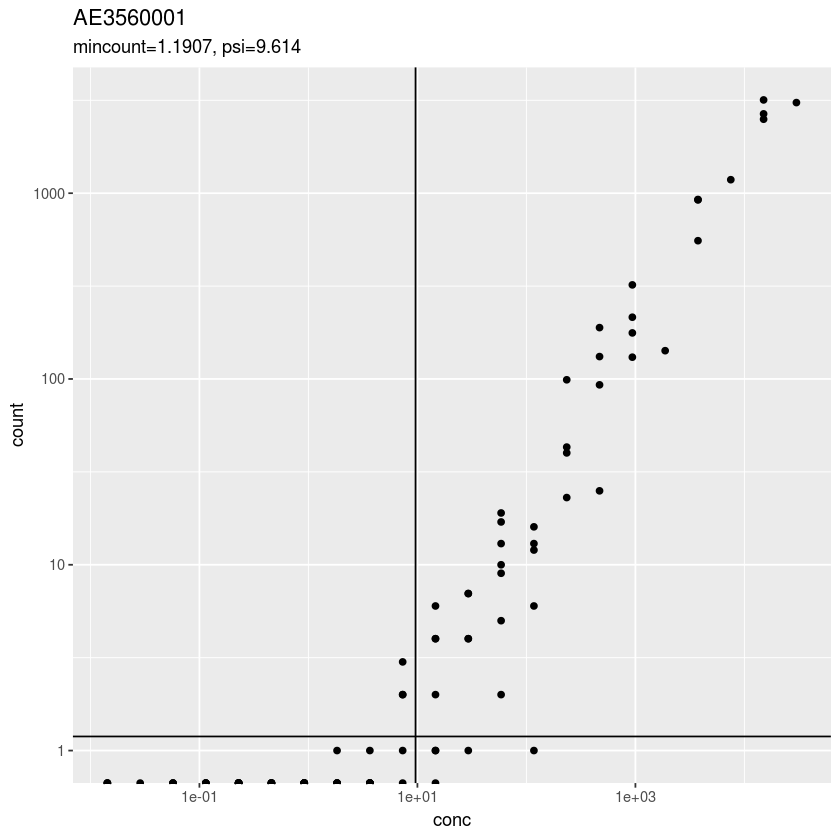

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

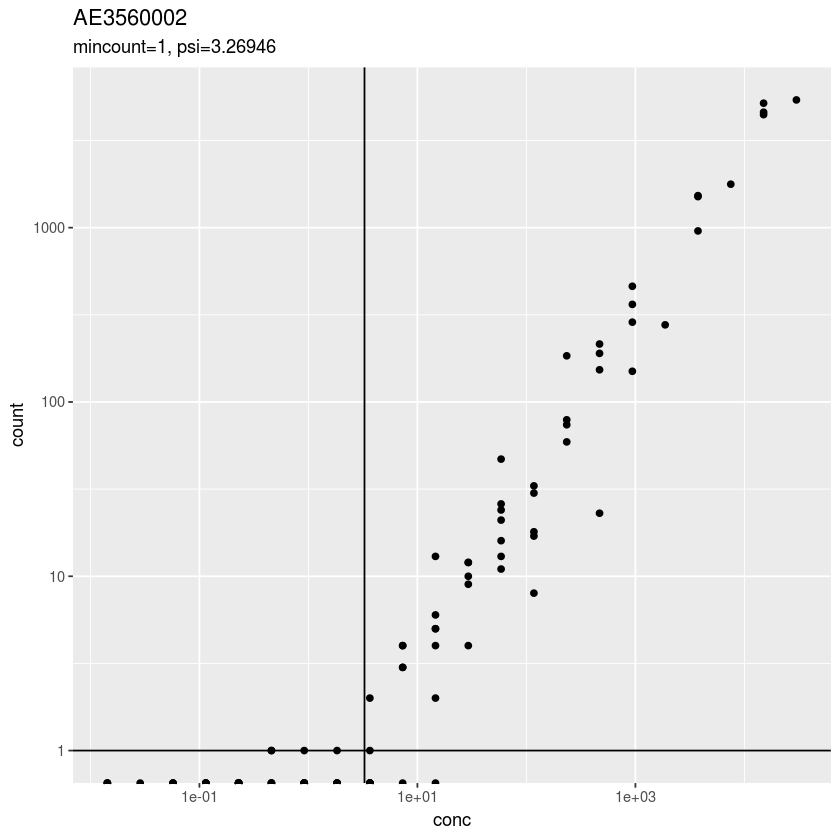

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

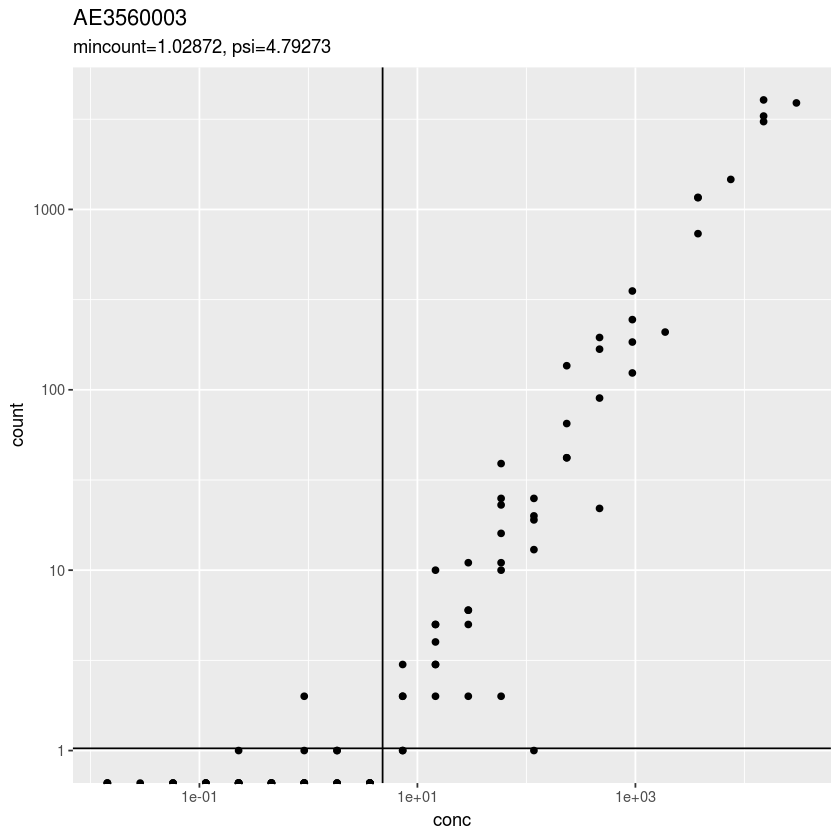

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

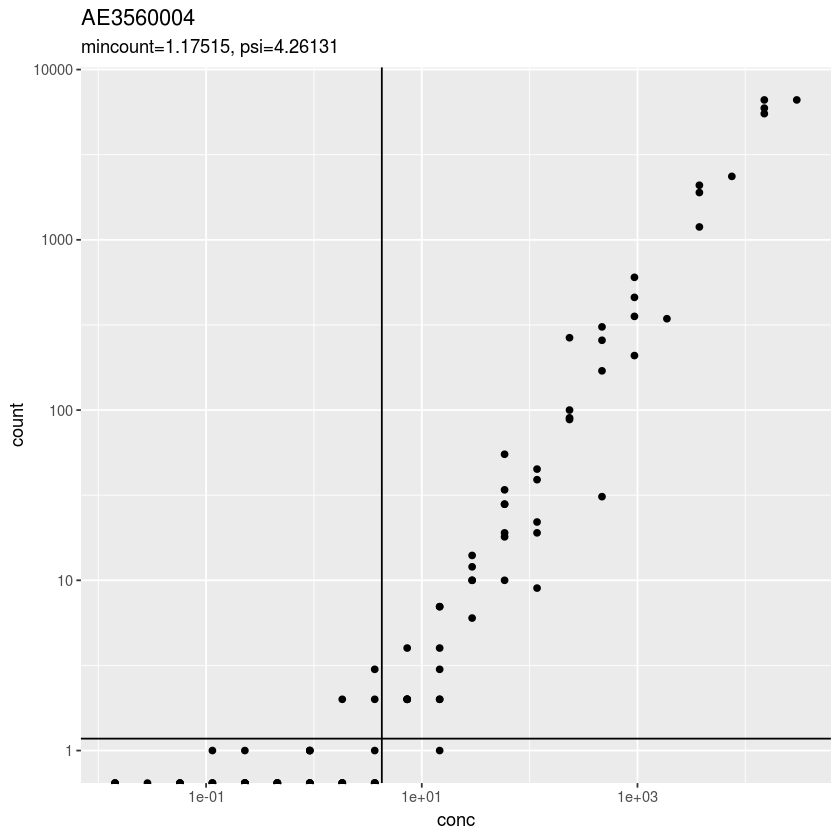

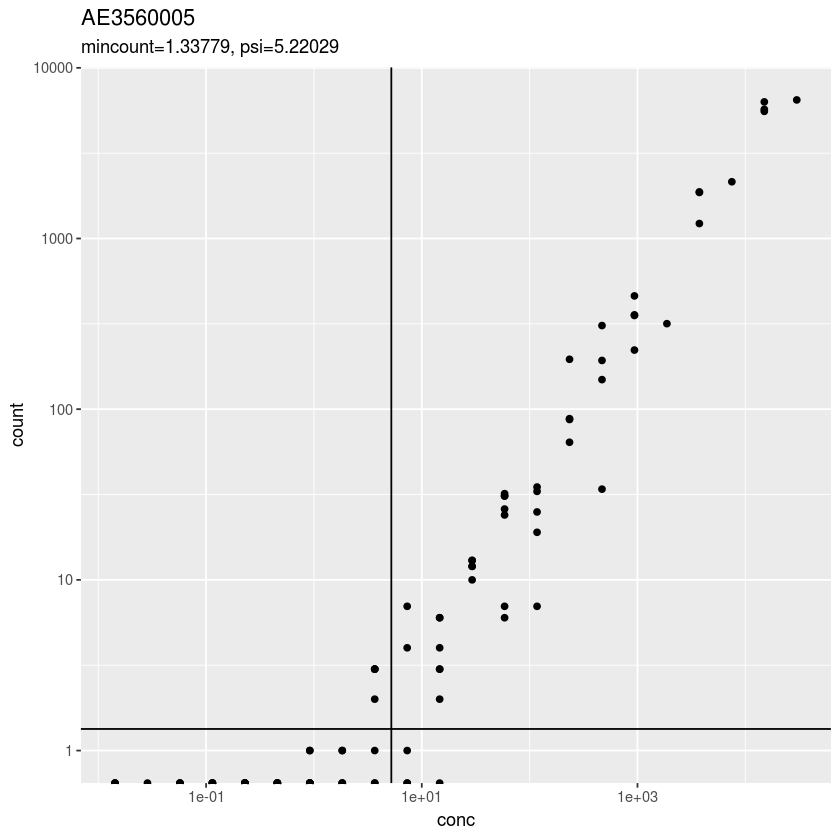

In [4]:
s <- unique(ercc_table$sample)[1:5]
for (i in s){
    # create sample-specific data frame
    sampleDF = ercc_table %>% filter(sample == i) %>% rename(conc = conc1) 
    #print(head(sampleDF))
    #print(dim(sampleDF))

    # find min count
    result<-findMinCount(sampleDF)
    mincount<-result$mincount
    psi<-result$psi
    #print(i)
    #print(mincount)
    #print(psi)

    # plot the dynamic range
    p <- ggplot(sampleDF,aes(conc,count)) +
    geom_point() +
    scale_x_log10() +
    scale_y_log10() +
    geom_vline(xintercept=psi) +
    geom_hline(yintercept=mincount) +
    labs(title=i, subtitle = paste('mincount=', round(mincount, digits=5), ', psi=', round(psi, digits=5), sep=""))
    print(p)
    
    # save to png file
    out_filename<-paste(i,'.expr.dynamic.range.png',sep="")
    png(filename=out_filename,width=1080, height=1080, res=130)
    plot(p)
    dev.off()
}

In [5]:
sampleList <- unique(ercc_table$sample)
minValueList <- numeric(length(sampleList))

for(i in 1:length(sampleList)){
    sampleDF <- ercc_table %>% filter(sample == sampleList[i]) %>% rename(conc = conc1)
    result <- findMinCount(sampleDF)
    minValueList[i]<-result$mincount
}

minDF<- data.frame(sample=sampleList, min_count=minValueList)
head(minDF)


sample,min_count
AE3560001,1.190699
AE3560002,1.000000
AE3560003,1.028715
AE3560004,1.175153
AE3560005,1.337795
AE3560006,1.087586


In [7]:
pathogen_counts_file<-"../../ae356_counts/AE356_Counts_pp_only.txt";
pathogen.data<-read.table(pathogen_counts_file,sep="\t",header=T,quote="",stringsAsFactors = F,check.names = F);
pathogen_counts <- pathogen.data[ , -c(1) ]
rownames( pathogen_counts ) <- pathogen.data[ , 1 ]
pathogen_counts[1:5,1:5]
dim(pathogen_counts)

,AE3560001,AE3560002,AE3560003,AE3560004,AE3560005
TRINITY_DN10000_c0_g1_i1,0,0,0,0,0
TRINITY_DN10000_c0_g1_i2,0,0,0,0,0
TRINITY_DN10000_c0_g1_i3,0,0,0,0,0
TRINITY_DN10000_c0_g1_i4,0,0,0,0,0
TRINITY_DN10000_c0_g1_i5,0,0,0,0,0


[1] 152383     95

In [6]:
effector_counts_file<-"../../ae356_counts/AE356_Counts_Soy_ASR_topEffectors.txt";
effector.data<-read.table(effector_counts_file,sep="\t",header=T,quote="",stringsAsFactors = F,check.names = F);
effector_counts <- effector.data[ , -c(1) ]
rownames( effector_counts ) <- effector.data[ , 1 ]
effector_counts[1:5,1:5]
dim(effector_counts)

,AE3560001,AE3560002,AE3560003,AE3560004,AE3560005
ASR_TopEffector_1,0,0,0,0,0
ASR_TopEffector_10,0,0,0,0,0
ASR_TopEffector_100,0,0,0,0,0
ASR_TopEffector_101,0,0,0,0,0
ASR_TopEffector_102,0,0,0,0,0


[1] 400  95

In [9]:
soy_counts_file<-"../../ae356_counts/AE356_Counts_dpgm_only.txt";
soy.data<-read.table(soy_counts_file,sep="\t",header=T,quote="",stringsAsFactors = F,check.names = F);
soy_counts <- soy.data[ , -c(1) ]
rownames( soy_counts ) <- soy.data[ , 1 ]
soy_counts[1:5,1:5]
dim(soy_counts)

,AE3560001,AE3560002,AE3560003,AE3560004,AE3560005
dpgm001g000100.11.1,0.00,0.00,0.00,0.00,0.00
dpgm001g000110.11.1,0.00,0.00,0.00,0.00,0.00
dpgm001g000120.11.1,0.00,0.00,0.00,0.00,0.00
dpgm001g000130.11.1,311.69,360.75,400.89,61.49,54.58
dpgm001g000140.11.1,0.00,0.00,3.44,7.68,0.00


[1] 97807    95

In [10]:
x <- "AE3560002"
x

sum(pathogen_counts[[x]] >= mincount)*100/nrow(pathogen_counts)
sum(soy_counts[[x]] >= mincount)*100/nrow(soy_counts)
sum(effector_counts[[x]] >= mincount)*100/nrow(effector_counts)

[1] "AE3560002"

[1] 2.457623

[1] 42.89775

[1] 1.5

In [11]:
totalExpr <- colSums(pathogen_counts) + colSums(soy_counts)
x <- numeric(5)

for(i in 1:5){
    p <- pathogen_counts[[sampleList[i]]]
    x[i] <- sum(subset(p, p >= minValueList[i]))*100/totalExpr[[sampleList[i]]]
}
#totalExpr
x

[1] 10.205483 10.138799 10.162519  7.053110  9.964378

In [10]:
totalPathogenGenes <- nrow(pathogen_counts)
totalSoyGenes <- nrow(soy_counts)
totalExpr <- colSums(pathogen_counts) + colSums(soy_counts)

numPathogen <- numeric(length(sampleList))
numSoy <- numeric(length(sampleList))
percentPathogen <- numeric(length(sampleList))
percentSoy <- numeric(length(sampleList))
exprPathogen <- numeric(length(sampleList))
exprSoy <- numeric(length(sampleList))

for(i in 1:length(sampleList)){
    p <- pathogen_counts[[sampleList[i]]]
    s <- soy_counts[[sampleList[i]]]
    numPathogen[i] <- sum(p >= minValueList[i])
    numSoy[i] <- sum(s >= minValueList[i])
    percentPathogen[i] <- numPathogen[i]*100/totalPathogenGenes
    percentSoy[i] <- numSoy[i]*100/totalSoyGenes
    exprPathogen[i] <- sum(subset(p, p >= minValueList[i]))*100/totalExpr[[sampleList[i]]]
    exprSoy[i] <- sum(subset(s, s >= minValueList[i]))*100/totalExpr[[sampleList[i]]]
}

geneDF<- data.frame(sample=sampleList, min_count_cutoff=minValueList, num_pathogen=numPathogen, num_soy=numSoy, percent_pathogen=percentPathogen, percent_soy=percentSoy, pathogen_expr=exprPathogen, soy_expr=exprSoy)
write.table(geneDF,paste(wd,"Sample.pathogen.soy.quantifiable.genes.txt",sep=""), sep="\t",row.names=F,col.names=T,quote=F)

In [15]:
head(geneDF)

sample,min_count_cutoff,num_pathogen,num_soy,percent_pathogen,percent_soy,pathogen_expr,soy_expr
AE3560001,1.190699,3663,41568,2.403811,42.50003,10.205483,89.75518
AE3560002,1.000000,3817,42658,2.504873,43.61447,10.138799,89.83304
AE3560003,1.028715,3757,43311,2.465498,44.28211,10.162519,89.81059
AE3560004,1.175153,3727,44278,2.445811,45.27079,7.053110,92.91335
AE3560005,1.337795,3456,40228,2.267970,41.12998,9.964378,89.98419
AE3560006,1.087586,3596,41409,2.359843,42.33746,7.728533,92.22385


In [7]:
numEffectors <- numeric(length(sampleList))
exprEffectors <- numeric(length(sampleList))
normexprEffectors <- numeric(length(sampleList))

for(i in 1:length(sampleList)){
    e <- effector_counts[[sampleList[i]]]
    numEffectors[i] <- sum(e >= minValueList[i])
    exprEffectors[i] <- sum(subset(e, e >= minValueList[i]))
    normexprEffectors[i] <- exprEffectors[i]/numEffectors[i]
}

effectorDF<- data.frame(sample=sampleList, min_count_cutoff=minValueList, num_effectors=numEffectors, effectors_expr=exprEffectors, norm_effectors_expr=normexprEffectors)
write.table(effectorDF,paste(wd,"Sample.quantifiable.effectors.txt",sep=""), sep="\t",row.names=F,col.names=T,quote=F)

In [8]:
head(effectorDF)

sample,min_count_cutoff,num_effectors,effectors_expr,norm_effectors_expr
AE3560001,1.190699,4,23,5.750000
AE3560002,1.000000,6,38,6.333333
AE3560003,1.028715,5,21,4.200000
AE3560004,1.175153,3,25,8.333333
AE3560005,1.337795,2,11,5.500000
AE3560006,1.087586,4,24,6.000000


png 
  2

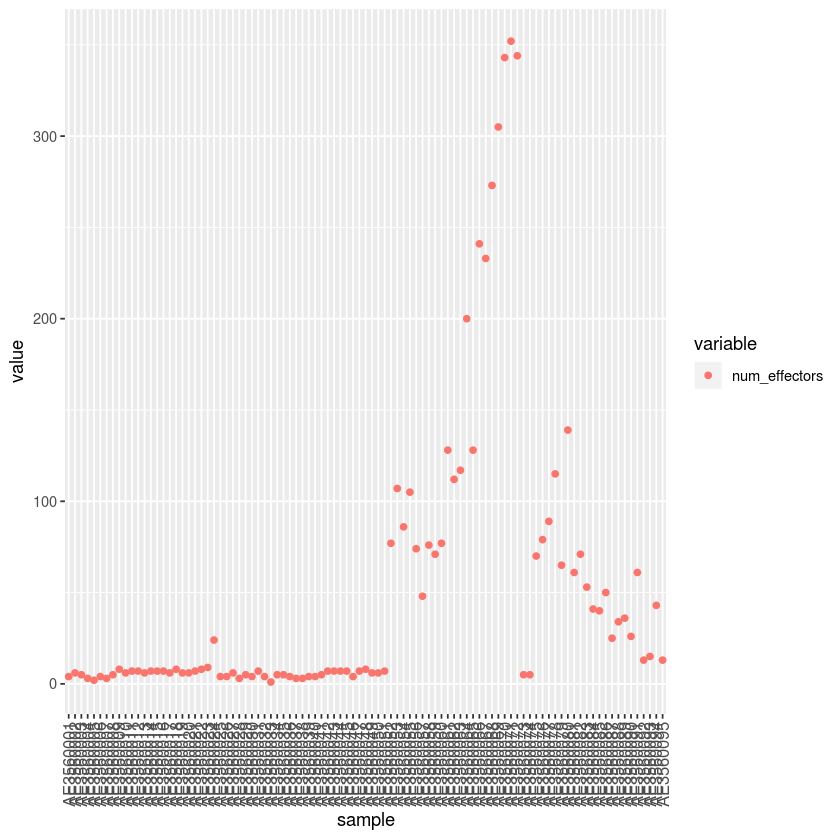

In [9]:
p <- ggplot(melt(effectorDF, measure.vars=c(3)), aes(x=sample, y=value, color=variable)) + geom_point() +
theme(axis.text.x = element_text(size=10,angle = 90, hjust =0.5, vjust=0.5))
p
png(filename="num.asr.effectors.png",width=1920, height=1080, res=130)
plot(p)
dev.off()

png 
  2

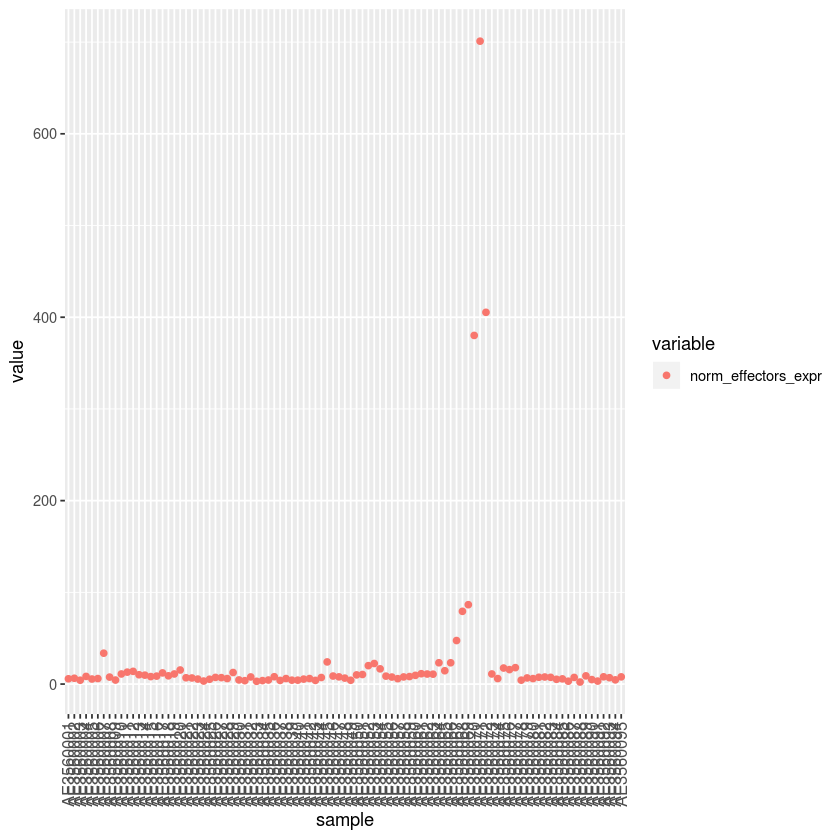

In [39]:
p <- ggplot(melt(effectorDF, measure.vars=c(5)), aes(x=sample, y=value, color=variable)) + geom_point() +
theme(axis.text.x = element_text(size=10,angle = 90, hjust =0.5, vjust=0.5))
p
png(filename="normexpr.asr.effectors.png",width=1920, height=1080, res=130)
plot(p)
dev.off()

png 
  2

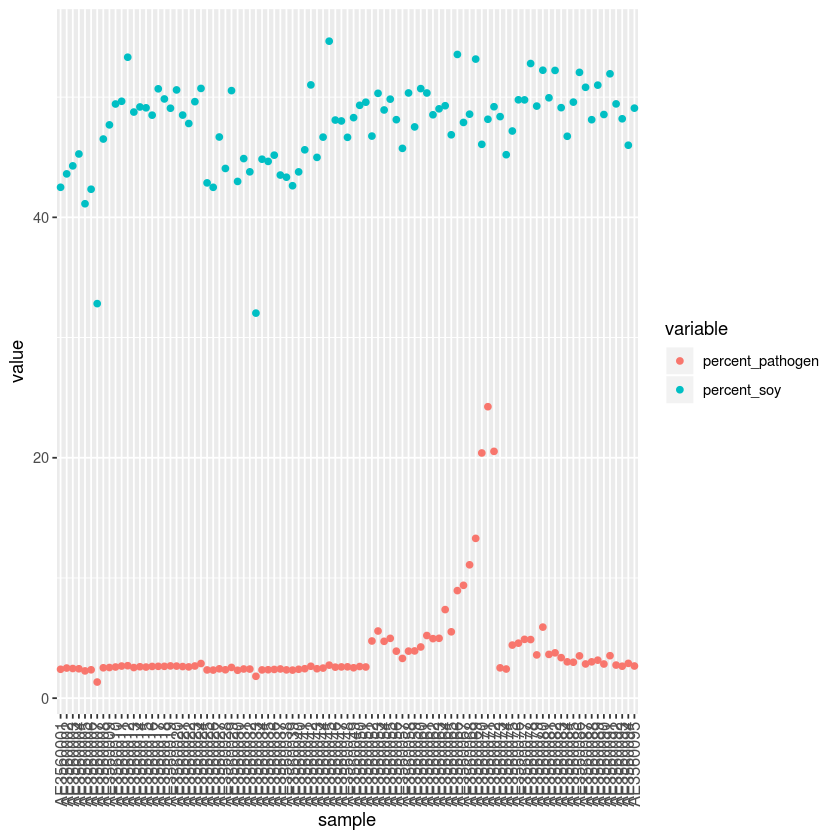

In [14]:
p <- ggplot(melt(geneDF, measure.vars=c(5, 6)), aes(x=sample, y=value, color=variable)) + geom_point() +
theme(axis.text.x = element_text(size=10,angle = 90, hjust =0.5, vjust=0.5))
p
png(filename="percent.path.soy.genes.png",width=1920, height=1080, res=130)
plot(p)
dev.off()

png 
  2

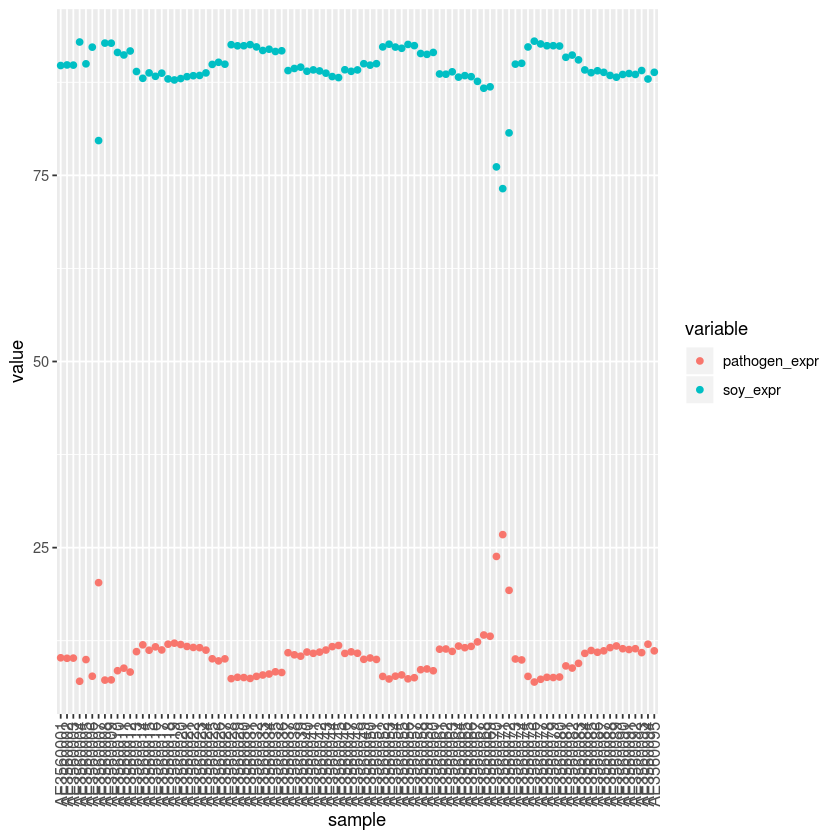

In [15]:
p <- ggplot(melt(geneDF, measure.vars=c(7, 8)), aes(x=sample, y=value, color=variable)) + geom_point() +
theme(axis.text.x = element_text(size=10,angle = 90, hjust =0.5, vjust=0.5))
p
png(filename="percent.path.soy.expr.png",width=1920, height=1080, res=130)
plot(p)
dev.off()

In [30]:
meta_file<-"../../ae356_counts/ae356-meta.txt";
meta_data<-read.table(meta_file,sep="\t",header=T,quote="",stringsAsFactors = F,check.names = F);
colnames(meta_data)[colnames(meta_data)=="Sample ID"] <- "sample"
head(meta_data)
meta_data %>% filter((Timepoint == 12 | Timepoint == 24) & Treatment=="ASR")

sample,Sample Name,Transgenic,Treatment,Timepoint,Group1,Group2
AE3560001,NM-0HAI1,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560002,NM-0HAI2,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560003,NM-0HAI3,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560004,NM-12HAI1,Null,Mock,12,Null.Mock,Null.Mock.12
AE3560005,NM-12HAI2,Null,Mock,12,Null.Mock,Null.Mock.12
AE3560006,NM-12HAI3,Null,Mock,12,Null.Mock,Null.Mock.12


sample,Sample Name,Transgenic,Treatment,Timepoint,Group1,Group2
AE3560052,NI-12HAI1,Null,ASR,12,Null.ASR,Null.ASR.12
AE3560053,NI-12HAI2,Null,ASR,12,Null.ASR,Null.ASR.12
AE3560054,NI-12HAI3,Null,ASR,12,Null.ASR,Null.ASR.12
AE3560055,NI-24HAI1,Null,ASR,24,Null.ASR,Null.ASR.24
AE3560056,NI-24HAI2,Null,ASR,24,Null.ASR,Null.ASR.24
AE3560057,NI-24HAI3,Null,ASR,24,Null.ASR,Null.ASR.24
AE3560075,PI-12HAI1,Transgene,ASR,12,Transgene.ASR,Transgene.ASR.12
AE3560076,PI-12HAI2,Transgene,ASR,12,Transgene.ASR,Transgene.ASR.12
AE3560077,PI-12HAI3,Transgene,ASR,12,Transgene.ASR,Transgene.ASR.12
AE3560078,PI-24HAI1,Transgene,ASR,24,Transgene.ASR,Transgene.ASR.24


In [12]:
finalDF <-merge(geneDF, meta_data, by="sample")
finalDF$Timepoint <- as.factor(finalDF$Timepoint)
head(finalDF)

sample,Sample Name,Transgenic,Treatment,Timepoint,Group1,Group2
AE3560001,NM-0HAI1,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560002,NM-0HAI2,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560003,NM-0HAI3,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560004,NM-12HAI1,Null,Mock,12,Null.Mock,Null.Mock.12
AE3560005,NM-12HAI2,Null,Mock,12,Null.Mock,Null.Mock.12
AE3560006,NM-12HAI3,Null,Mock,12,Null.Mock,Null.Mock.12


sample,min_count_cutoff,num_pathogen,num_soy,percent_pathogen,percent_soy,pathogen_expr,soy_expr,Sample Name,Transgenic,Treatment,Timepoint,Group1,Group2
AE3560001,1.190699,3663,41568,2.403811,42.50003,10.205483,89.75518,NM-0HAI1,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560002,1.000000,3817,42658,2.504873,43.61447,10.138799,89.83304,NM-0HAI2,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560003,1.028715,3757,43311,2.465498,44.28211,10.162519,89.81059,NM-0HAI3,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560004,1.175153,3727,44278,2.445811,45.27079,7.053110,92.91335,NM-12HAI1,Null,Mock,12,Null.Mock,Null.Mock.12
AE3560005,1.337795,3456,40228,2.267970,41.12998,9.964378,89.98419,NM-12HAI2,Null,Mock,12,Null.Mock,Null.Mock.12
AE3560006,1.087586,3596,41409,2.359843,42.33746,7.728533,92.22385,NM-12HAI3,Null,Mock,12,Null.Mock,Null.Mock.12


sample,min_count_cutoff,num_effectors,effectors_expr,norm_effectors_expr,Sample Name,Transgenic,Treatment,Timepoint,Group1,Group2
AE3560001,1.190699,4,23,5.750000,NM-0HAI1,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560002,1.000000,6,38,6.333333,NM-0HAI2,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560003,1.028715,5,21,4.200000,NM-0HAI3,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560004,1.175153,3,25,8.333333,NM-12HAI1,Null,Mock,12,Null.Mock,Null.Mock.12
AE3560005,1.337795,2,11,5.500000,NM-12HAI2,Null,Mock,12,Null.Mock,Null.Mock.12
AE3560006,1.087586,4,24,6.000000,NM-12HAI3,Null,Mock,12,Null.Mock,Null.Mock.12


In [11]:
finalEffectorDF <-merge(effectorDF, meta_data, by="sample")
finalEffectorDF$Timepoint <- as.factor(finalEffectorDF$Timepoint)
head(finalEffectorDF)

sample,min_count_cutoff,num_effectors,effectors_expr,norm_effectors_expr,Sample Name,Transgenic,Treatment,Timepoint,Group1,Group2
AE3560001,1.190699,4,23,5.750000,NM-0HAI1,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560002,1.000000,6,38,6.333333,NM-0HAI2,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560003,1.028715,5,21,4.200000,NM-0HAI3,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560004,1.175153,3,25,8.333333,NM-12HAI1,Null,Mock,12,Null.Mock,Null.Mock.12
AE3560005,1.337795,2,11,5.500000,NM-12HAI2,Null,Mock,12,Null.Mock,Null.Mock.12
AE3560006,1.087586,4,24,6.000000,NM-12HAI3,Null,Mock,12,Null.Mock,Null.Mock.12


png 
  2

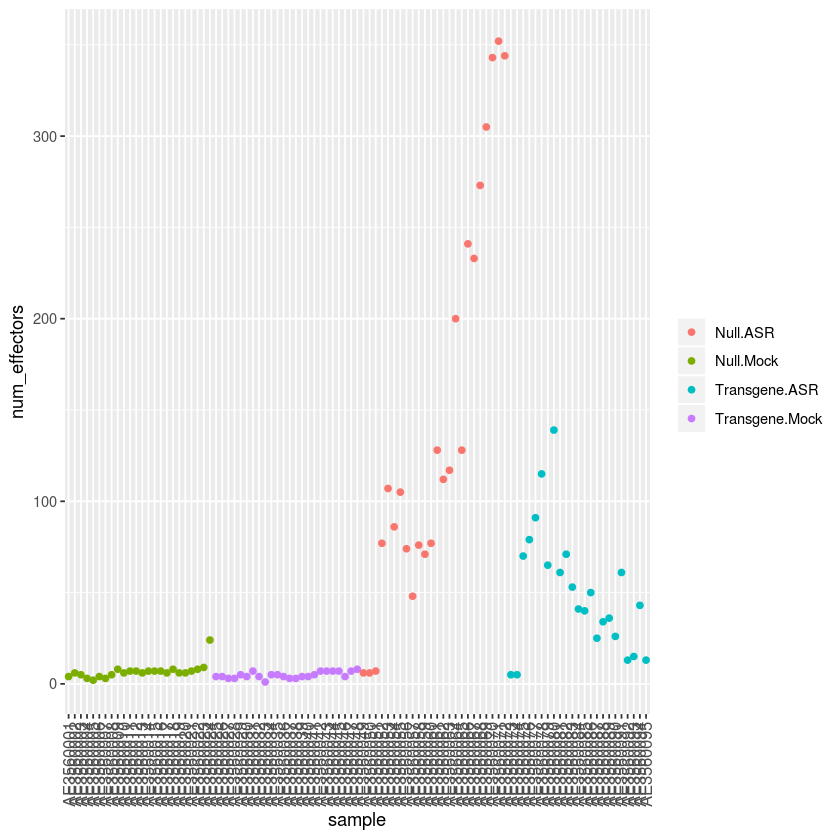

In [31]:
p <-ggplot(finalEffectorDF, aes(x=sample, y=num_effectors, color = Group1)) + geom_point() +
labs(color = "") +
theme(axis.text.x = element_text(size=10,angle = 90, hjust =0.5, vjust=0.5))
p
png(filename="num.effectors.bygroup.png",width=1920, height=1080, res=130)
plot(p)
dev.off()

png 
  2

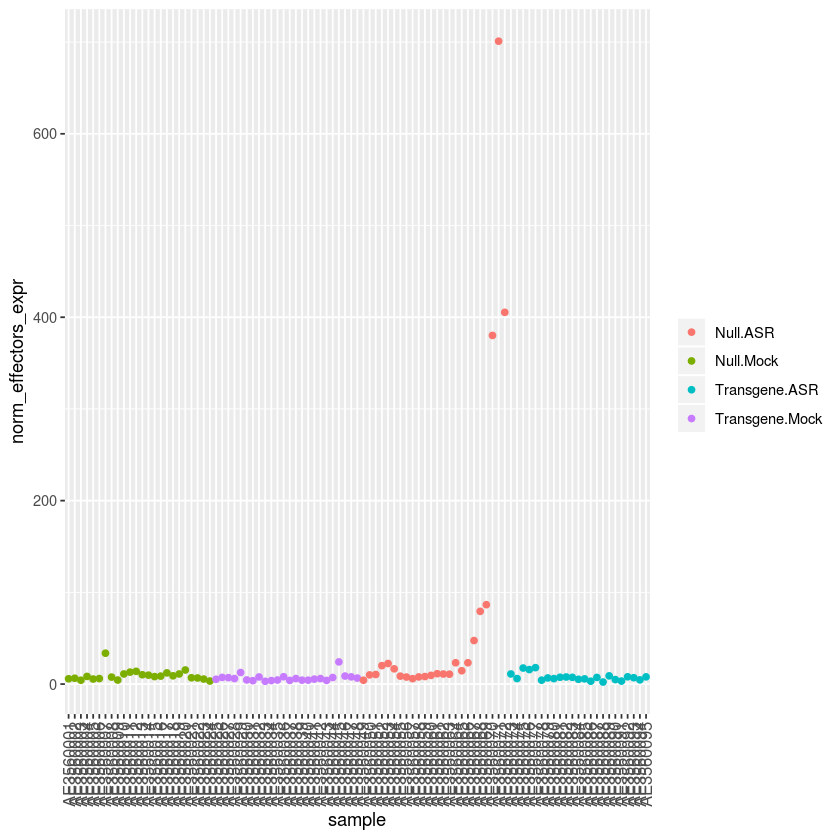

In [41]:
p <-ggplot(finalEffectorDF, aes(x=sample, y=norm_effectors_expr, color = Group1)) + geom_point() +
labs(color = "") +
theme(axis.text.x = element_text(size=10,angle = 90, hjust =0.5, vjust=0.5))
p
png(filename="normexpr.effectors.bygroup.png",width=1920, height=1080, res=130)
plot(p)
dev.off()

png 
  2

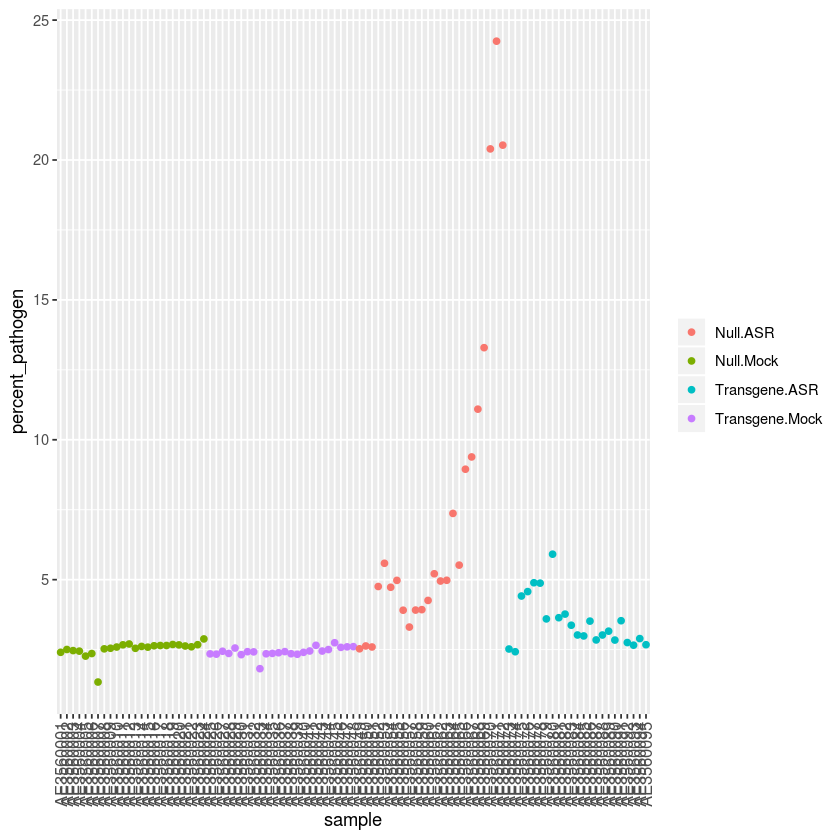

In [17]:
p <-ggplot(finalDF, aes(x=sample, y=percent_pathogen, color = Group1)) + geom_point() +
labs(color = "") +
theme(axis.text.x = element_text(size=10,angle = 90, hjust =0.5, vjust=0.5))
p
png(filename="percent.pathogen.genes.bygroup.png",width=1920, height=1080, res=130)
plot(p)
dev.off()

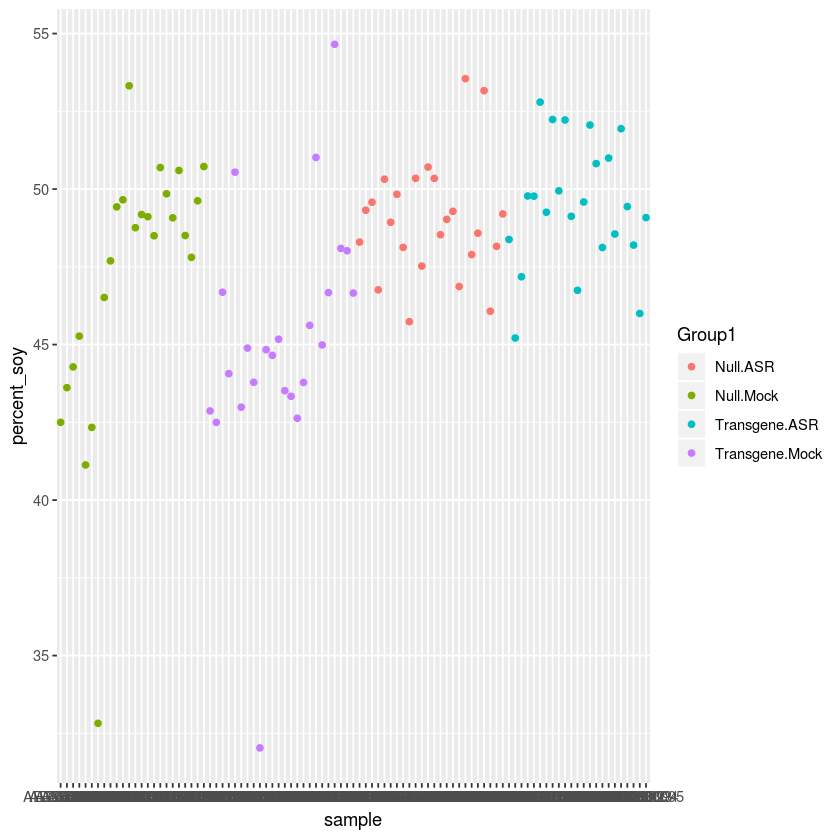

In [18]:
ggplot(finalDF, aes(x=sample, y=percent_soy, color = Group1)) + geom_point()

png 
  2

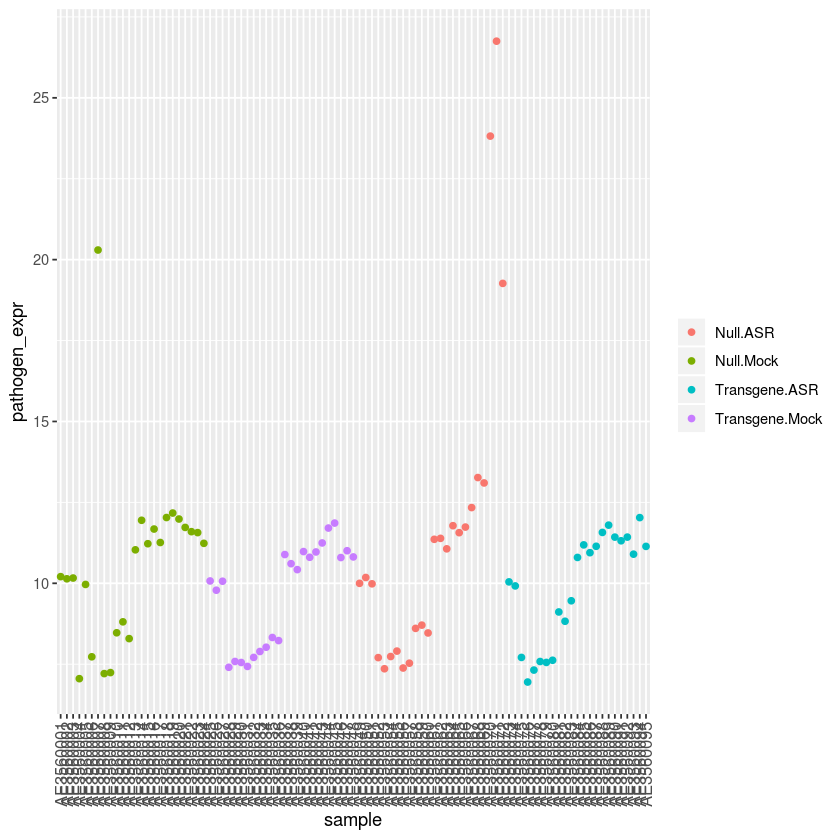

In [19]:
p <-ggplot(finalDF, aes(x=sample, y=pathogen_expr, color = Group1)) + geom_point() +
labs(color = "") +
theme(axis.text.x = element_text(size=10,angle = 90, hjust =0.5, vjust=0.5))
p
png(filename="percent.pathogen.expr.bygroup.png",width=1920, height=1080, res=130)
plot(p)
dev.off()

png 
  2

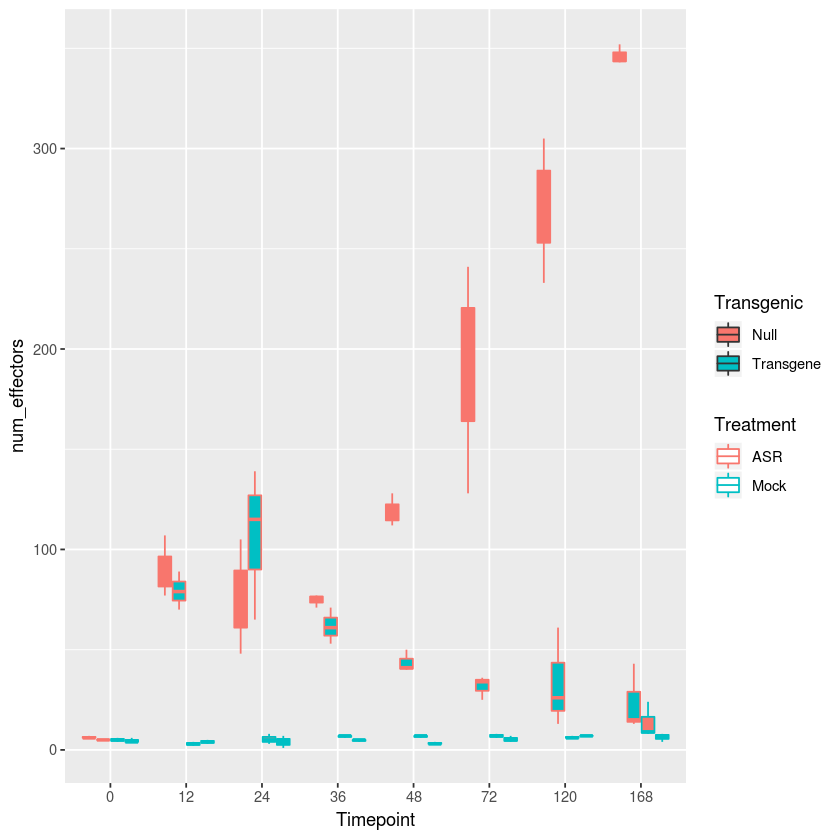

In [12]:
p <-ggplot(finalEffectorDF, aes(x=Timepoint, y=num_effectors, color = Treatment, fill=Transgenic)) + geom_boxplot()
p
png(filename="num.effectors.timepoint.png",width=1080, height=1080, res=130)
plot(p)
dev.off()
#ggplot(finalDF, aes(x=Timepoint, y=percent_pathogen, color = Group1)) + geom_boxplot()

In [20]:
#plot_data <- ggplot_build(p)
#head(plot_data$data[[1]])
#layer_data(p, 1)[ymin]

png 
  2

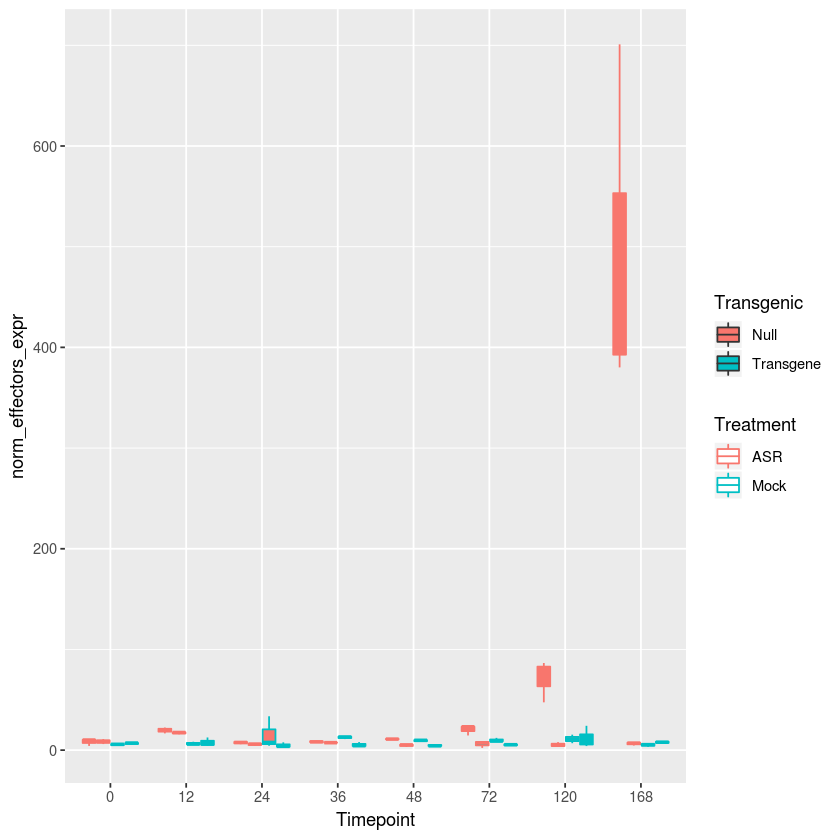

In [42]:
p <-ggplot(finalEffectorDF, aes(x=Timepoint, y=norm_effectors_expr, color = Treatment, fill=Transgenic)) + geom_boxplot()
p
png(filename="normexpr.effectors.timepoint.png",width=1080, height=1080, res=130)
plot(p)
dev.off()
#ggplot(finalDF, aes(x=Timepoint, y=percent_pathogen, color = Group1)) + geom_boxplot()

png 
  2

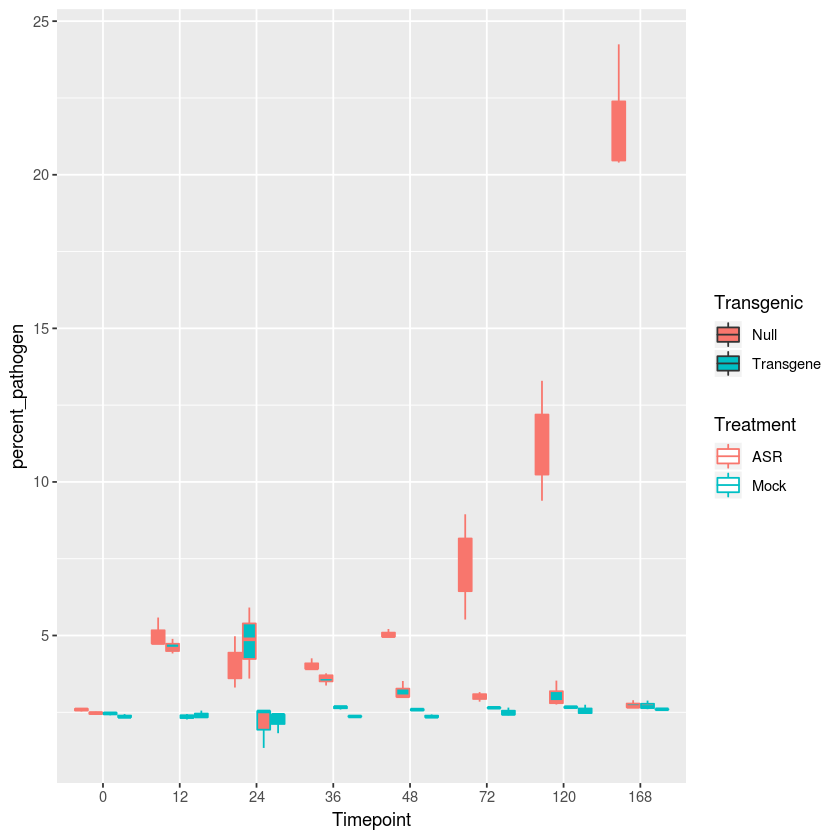

In [20]:
p <-ggplot(finalDF, aes(x=Timepoint, y=percent_pathogen, color = Treatment, fill=Transgenic)) + geom_boxplot()
p
png(filename="percent.pathogen.genes.timepoint.png",width=1080, height=1080, res=130)
plot(p)
dev.off()
#ggplot(finalDF, aes(x=Timepoint, y=percent_pathogen, color = Group1)) + geom_boxplot()

png 
  2

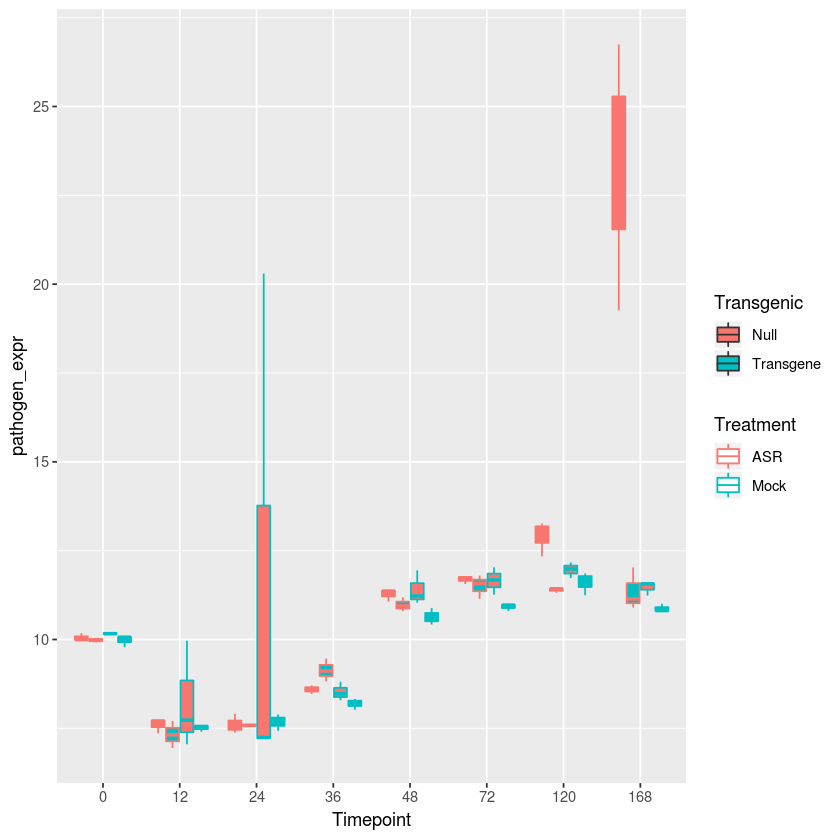

In [21]:
p <-ggplot(finalDF, aes(x=Timepoint, y=pathogen_expr, color = Treatment, fill=Transgenic)) + geom_boxplot()
p
png(filename="percent.pathogen.expr.timepoint.png",width=1080, height=1080, res=130)
plot(p)
dev.off()

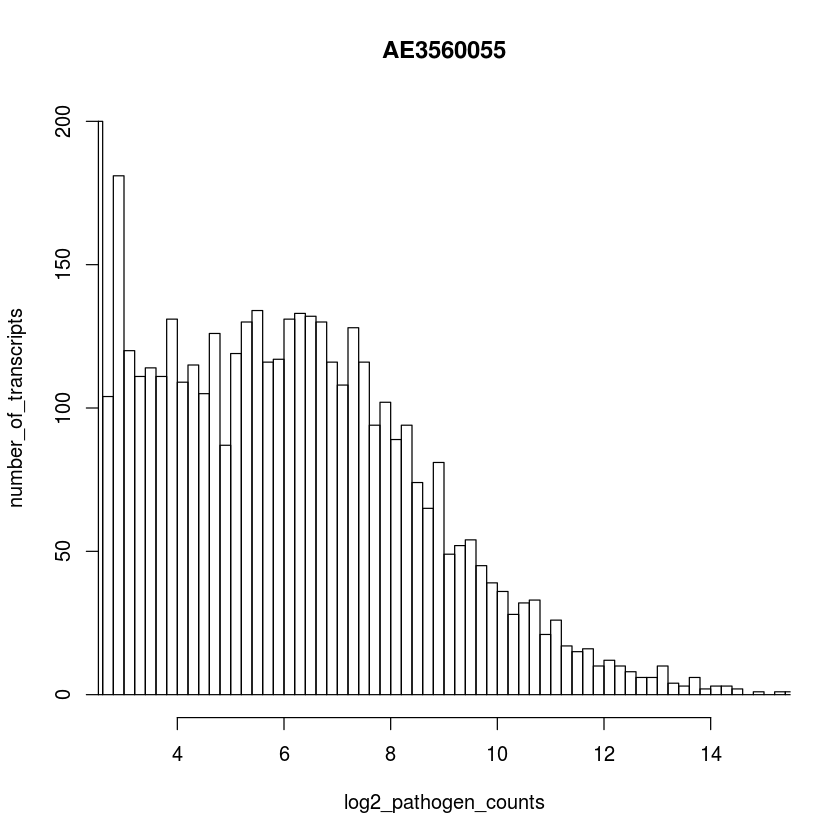

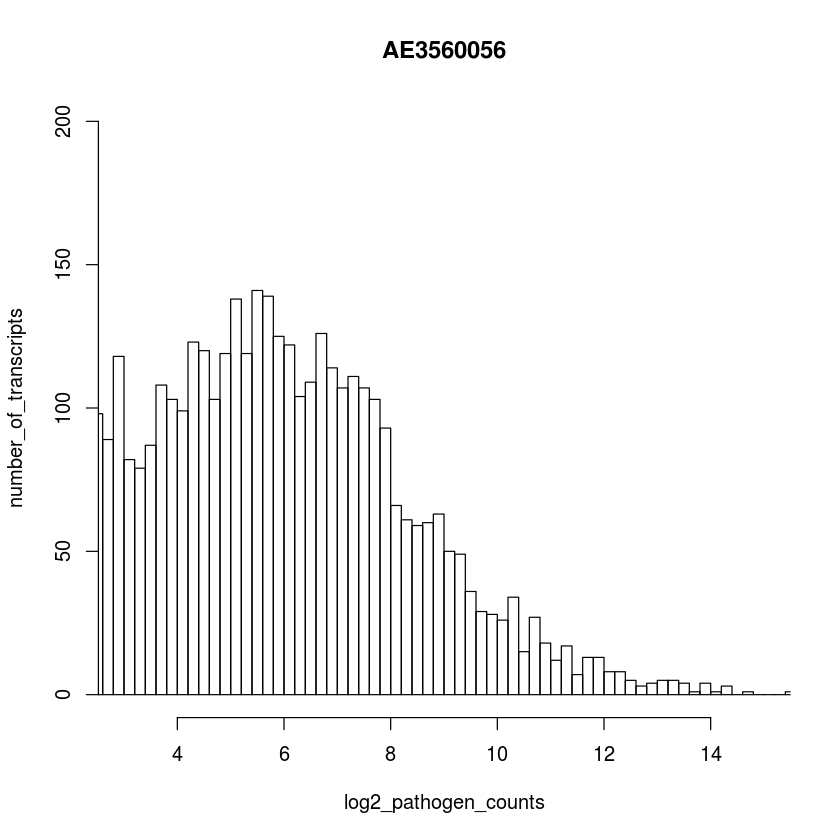

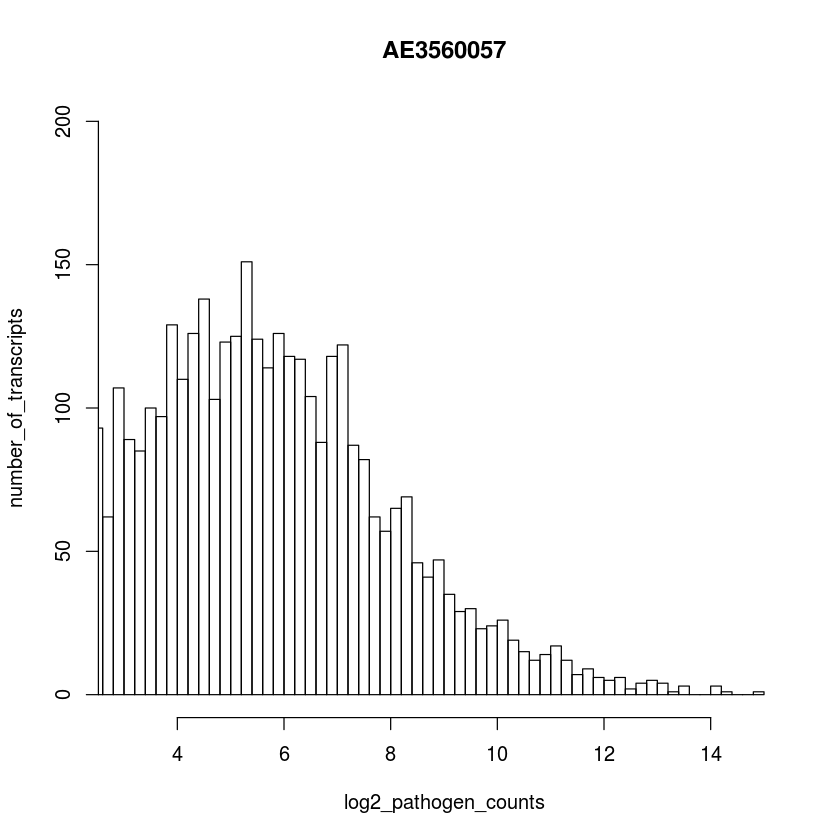

In [36]:
my_samples <- (finalDF %>% filter(Treatment=="ASR" & Transgenic=="Null" & Timepoint=="24"))[[1]]
#my_samples
for(i in 1:length(sampleList)){
    if(sampleList[i] %in% my_samples){
        p <- pathogen_counts[[sampleList[i]]]
        fp <- subset(p, p >= minValueList[i])
        # save to png file
        out_filename<-paste(sampleList[i],'.pathogen.gene.distribution.png',sep="")
        #png(filename=out_filename,width=1080, height=1080, res=130)
        hist(log2(fp), breaks=100, xlim=c(3,15), ylim=c(0,200), main=sampleList[i], xlab="log2_pathogen_counts", ylab="number_of_transcripts")
        #dev.off()
    }
}

,AE3560049,AE3560050,AE3560051,AE3560052,AE3560053
ASR_TopEffector_1,0,0,0,1,0.99
ASR_TopEffector_10,0,0,0,0,0.00
ASR_TopEffector_100,0,0,0,1,3.00
ASR_TopEffector_101,0,0,0,0,0.00
ASR_TopEffector_102,0,0,0,0,0.00


[1] 400  47

[1] 83 47

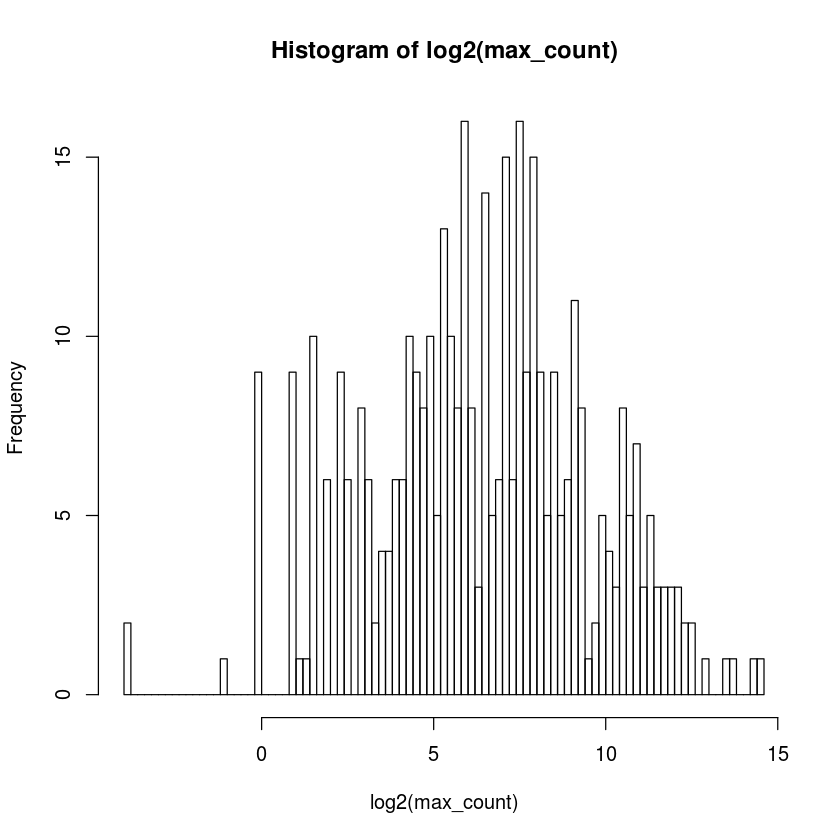

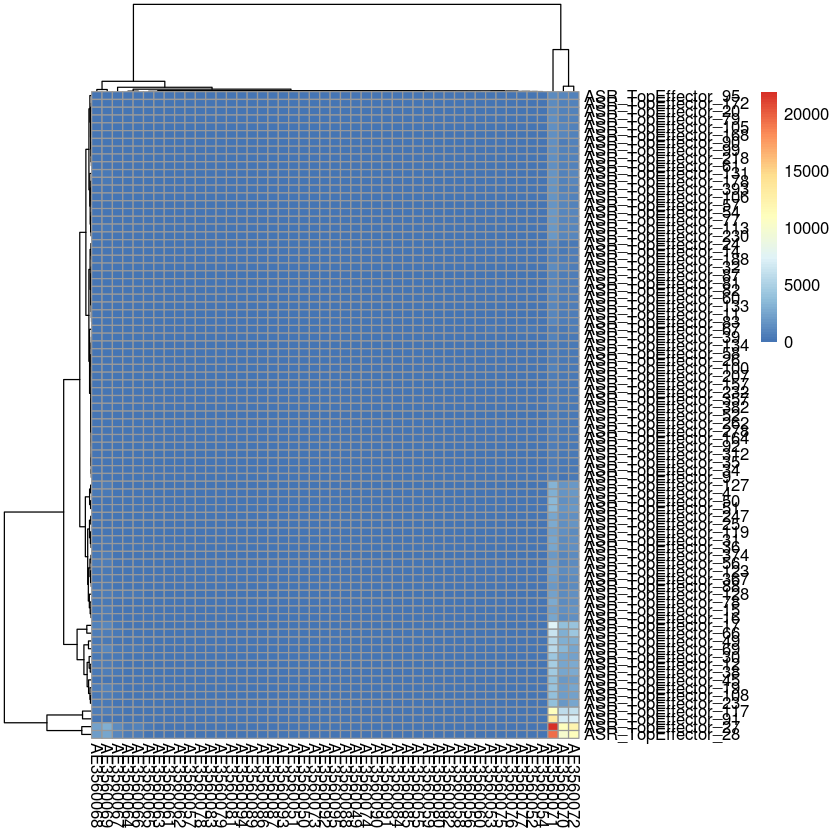

In [7]:
#norm_effector_counts <- effector_counts / colSums(effector_counts)
#norm_effector_counts[1:5, 66:75]

asr_sample_effector_counts <- effector_counts[, 49:ncol(effector_counts)]
asr_sample_effector_counts[1:5, 1:5]
dim(asr_sample_effector_counts)

count_data <- asr_sample_effector_counts
min_count_cutoff<-500
max_count<-apply(count_data,1,max)
hist(log2(max_count),breaks=100)

filt_count_data<-count_data[max_count >= min_count_cutoff,]
dim(filt_count_data)
pheatmap(filt_count_data)

sample,Sample Name,Transgenic,Treatment,Timepoint,Group1,Group2
AE3560001,NM-0HAI1,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560002,NM-0HAI2,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560003,NM-0HAI3,Null,Mock,0,Null.Mock,Null.Mock.0
AE3560004,NM-12HAI1,Null,Mock,12,Null.Mock,Null.Mock.12
AE3560005,NM-12HAI2,Null,Mock,12,Null.Mock,Null.Mock.12
AE3560006,NM-12HAI3,Null,Mock,12,Null.Mock,Null.Mock.12


,Group
AE3560001,Null.Mock.0
AE3560002,Null.Mock.0
AE3560003,Null.Mock.0
AE3560004,Null.Mock.12
AE3560005,Null.Mock.12
AE3560006,Null.Mock.12


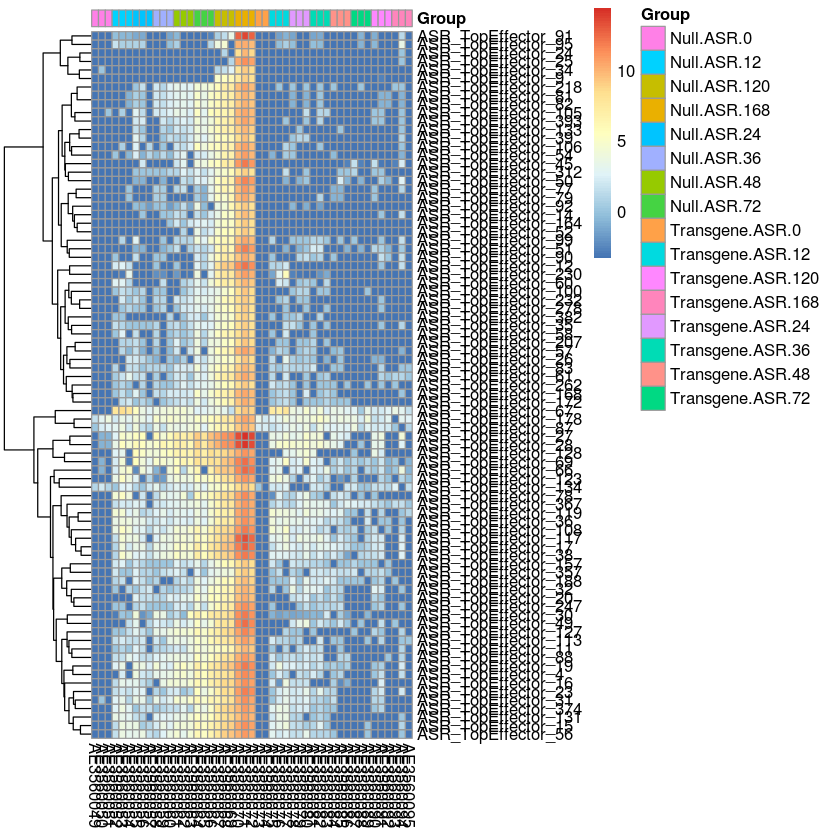

In [11]:
head(meta_data)
#my_sample_col <- data.frame(Timepoint = paste(meta_data[[5]], "hpi", sep=""))
my_sample_col <- data.frame(Group = meta_data[[7]])
rownames(my_sample_col) <- meta_data[[1]]
head(my_sample_col)
# adding 0.1 to avoid zeros for log2
data_subset <- filt_count_data + 0.1
pheatmap(log2(data_subset), annotation_col = my_sample_col, cluster_cols=FALSE)
